# Predicting Returns Using a Stable Proxy

Raw returns are inherently noisy and dominated by short-term fluctuations, making them difficult to predict directly.  

Instead of forecasting these unstable signals, we can target a smoother and more structured proxy, such as the *future linear slope*.  
This variable captures the **average direction and intensity** of price movements over a defined horizon, reducing entropy while preserving the underlying economic meaning.  

By reframing the prediction target this way, we move from modeling randomness to modeling **market structure**.


👉 Free newsletter : https://www.newsletter.quantreo.com/


### Import librairies + dataset

In [ ]:
!pip install quantreo

In [ ]:
# Quantreo feature engineering
import quantreo.features_engineering as fe

# Numerical tools
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [ ]:
# Load a generated OHLCV dataset
from quantreo.datasets import load_generated_ohlcv
df = load_generated_ohlcv()
df = df.loc["2016"]

df

,open,high,low,close,volume
time,,,,,
2016-01-04 00:00:00,104.944241,105.312073,104.929735,105.232289,576.805768
2016-01-04 04:00:00,105.233361,105.252139,105.047564,105.149357,485.696723
2016-01-04 08:00:00,105.159851,105.384745,105.141110,105.330306,403.969745
2016-01-04 12:00:00,105.330306,105.505799,104.894155,104.923404,1436.917324
2016-01-04 16:00:00,104.914147,105.023293,104.913252,105.014347,1177.672605
...,...,...,...,...,...
2016-12-30 04:00:00,103.632257,103.711884,103.495896,103.564574,563.932484
2016-12-30 08:00:00,103.564574,103.629321,103.555581,103.616731,697.707475
2016-12-30 12:00:00,103.615791,103.628165,103.496810,103.515847,1768.926665


<br>

### 1. Measuring Correlation Between Returns and Linear Slope

Here, we compute one-month returns and the corresponding linear slope using the same rolling window.

By aligning both variables over identical horizons, we can assess how strongly the **trend strength (slope)** and **price change (returns)** move together.  
This provides a structural view of their relationship, not on a tick-by-tick basis, but over consistent market intervals.

In [ ]:
# --- Create returns and trend feature ---
window_size = 30 * 6
df["returns_1M"] = df["close"].pct_change(window_size)
df["linear_slope_1M"] = fe.trend.linear_slope(df, col="close", window_size=window_size)

# Drop NaN values caused by rolling window initialization
df = df.dropna(subset=["returns_1M", "linear_slope_1M"])

# --- Compute correlations ---
pearson_corr = df["returns_1M"].corr(df["linear_slope_1M"], method="pearson")
spearman_corr = df["returns_1M"].corr(df["linear_slope_1M"], method="spearman")
kendall_corr = df["returns_1M"].corr(df["linear_slope_1M"], method="kendall")

# --- Display results ---
print("Correlation between returns and linear slope (same window):")
print(f" Pearson  : {pearson_corr:.4f}")
print(f" Spearman : {spearman_corr:.4f}")

Correlation between returns and linear slope (same window):
 Pearson  : 0.9205
 Spearman : 0.8527


<br>

### 2. Comparing the Spectral Entropy of Returns and Linear Slope

We compute the **spectral entropy** of both variables to evaluate their complexity in the frequency domain.  

A lower entropy indicates a more structured or predictable signal, while a higher value reflects noise and irregularity.  

By comparing the entropy of returns and the linear slope, we can determine whether the slope, despite being highly correlated with returns, carries a **more organized and learnable structure**.


In [ ]:
# --- Compute spectral entropy for both variables ---
window_entropy = 60  # smaller window to capture local frequency dynamics

df["spectral_entropy_returns"] = fe.math.spectral_entropy(df=df, col="returns_1M", window_size=window_entropy)
df["spectral_entropy_slope"] = fe.math.spectral_entropy(df=df, col="linear_slope_1M", window_size=window_entropy)

# Drop NaN values from the entropy calculations
df = df.dropna(subset=["spectral_entropy_returns", "spectral_entropy_slope"])

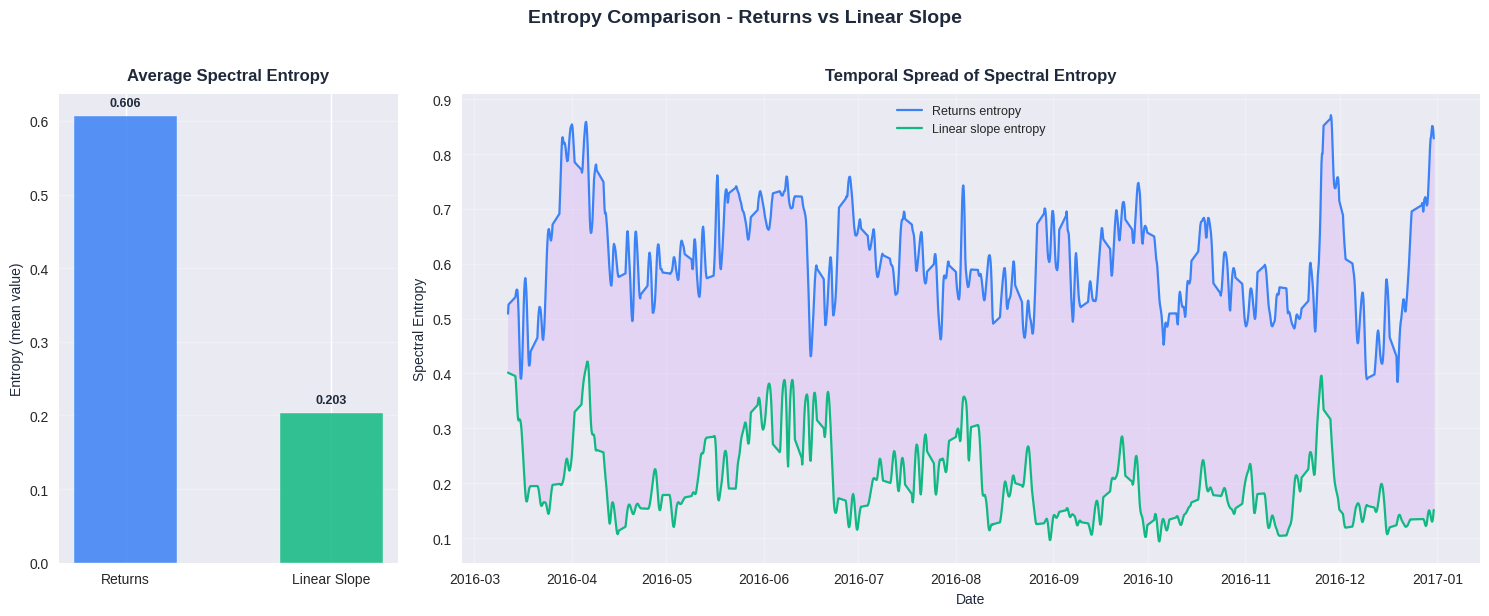

In [ ]:
# --- 1. Compute mean entropies ---
mean_entropy_returns = df["spectral_entropy_returns"].mean()
mean_entropy_slope = df["spectral_entropy_slope"].mean()
entropy_diff = df["spectral_entropy_returns"] - df["spectral_entropy_slope"]

# --- 2. Setup layout ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), gridspec_kw={'width_ratios': [1, 3]})
plt.subplots_adjust(wspace=0.25)

# --- Color palette ---
c_returns = "#3B82F6"     # bright steel blue
c_slope   = "#10B981"     # turquoise / green-teal
c_fill_hi = "#D193FD"     # soft blue fill
c_fill_lo = "#FDCD93"     # soft mint fill
c_text    = "#1E293B"     # dark grey text (good for light mode)

# === LEFT PLOT: Mean entropy comparison ===
bars = ax1.bar(
    ["Returns", "Linear Slope"],
    [mean_entropy_returns, mean_entropy_slope],
    color=[c_returns, c_slope],
    alpha=0.85,
    width=0.5,
    edgecolor="white"
)
ax1.set_title("Average Spectral Entropy", fontsize=12, weight="bold", color=c_text, pad=10)
ax1.set_ylabel("Entropy (mean value)", fontsize=10, color=c_text)
ax1.grid(axis="y", alpha=0.25)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}",
             ha='center', va='bottom', fontsize=9, weight='bold', color=c_text)

# === RIGHT PLOT: Entropy spread over time ===
ax2.plot(df.index, df["spectral_entropy_returns"], color=c_returns, lw=1.6, label="Returns entropy")
ax2.plot(df.index, df["spectral_entropy_slope"], color=c_slope, lw=1.6, label="Linear slope entropy")

# Fill area (positive spread = returns more entropic)
ax2.fill_between(df.index, df["spectral_entropy_returns"], df["spectral_entropy_slope"],
                 where=entropy_diff>0, color=c_fill_hi, alpha=0.25)
ax2.fill_between(df.index, df["spectral_entropy_returns"], df["spectral_entropy_slope"],
                 where=entropy_diff<0, color=c_fill_lo, alpha=0.25)

ax2.set_title("Temporal Spread of Spectral Entropy", fontsize=12, weight="bold", color=c_text, pad=10)
ax2.set_xlabel("Date", fontsize=10, color=c_text)
ax2.set_ylabel("Spectral Entropy", fontsize=10, color=c_text)
ax2.legend(frameon=False, fontsize=9)
ax2.grid(alpha=0.25)

# --- Style tuning for light mode ---
fig.patch.set_facecolor('white')
for ax in [ax1, ax2]:
    for spine in ax.spines.values():
        spine.set_alpha(0.25)
        spine.set_color("#94A3B8")  # neutral grey-blue

plt.suptitle("Entropy Comparison - Returns vs Linear Slope", fontsize=14, weight="bold", color=c_text, y=1.02)
plt.tight_layout()
plt.show()

## Conclusion

This analysis highlights that **returns and the linear slope are strongly correlated**, meaning they carry similar directional information about price dynamics.  
However, their **spectral entropy profiles differ significantly**, returns exhibit high entropy (noisy, unstable), while the linear slope remains much more structured and predictable.

Because of this difference in complexity, the **linear slope can serve as a robust proxy for returns**: it captures the same underlying movement but in a **lower-entropy, smoother form**.

This makes it a better target for modeling and prediction, especially when the goal is to forecast the **direction or intensity of future price movements**, rather than the exact numerical return.

In short, returns describe the market’s noise, while the slope reveals its structure.
